In [1]:
import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
#import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from utils.metrics import evaluate
from bayes_opt import BayesianOptimization
from fbprophet import Prophet
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm




# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

air_pollution = pd.read_csv('datasets/air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)

Importing plotly failed. Interactive plots will not work.


2.3.0


## Prepare data before modeling

In [2]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

air_pollution = pd.read_csv('C:/Users/hp/Downloads/time-series-forecasting-with-python-master/datasets/air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)

split_date = '2014-01-01'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('datasets/training.csv')
df_test.to_csv('datasets/test.csv')

1461 days of training data 
 364 days of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

In [3]:
# Also add the naive mean average value
mean = df_training.pollution_today.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.pollution_today, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(
    df_test.pollution_today, df_test.pollution_yesterday)
predictionsDict['Yesterdays value'] = df_test.pollution_yesterday.values

### Simple Exponential Smoothing (SES)

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

In [4]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 364/364 [00:06<00:00, 53.29it/s]


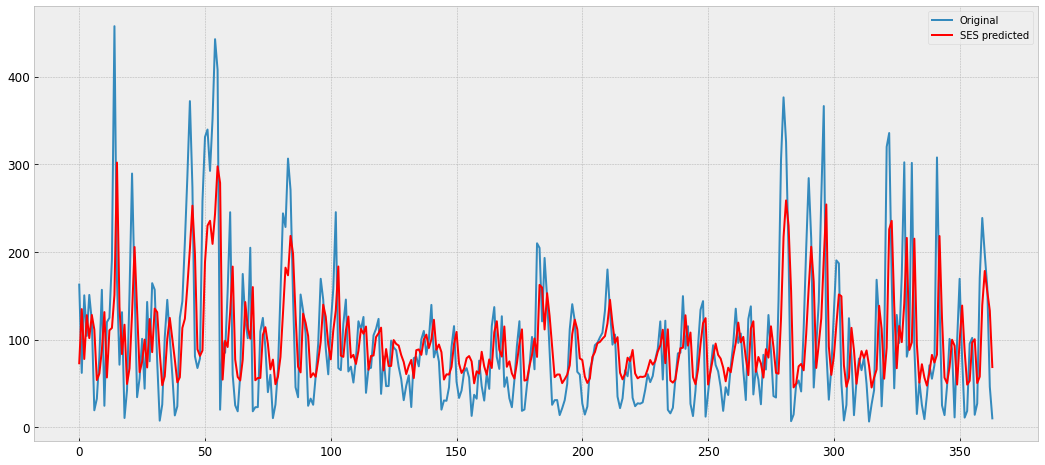

In [8]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='SES predicted')
plt.legend()

### Holt Winter’s Exponential Smoothing (HWES)

In [5]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 364/364 [00:06<00:00, 53.03it/s]


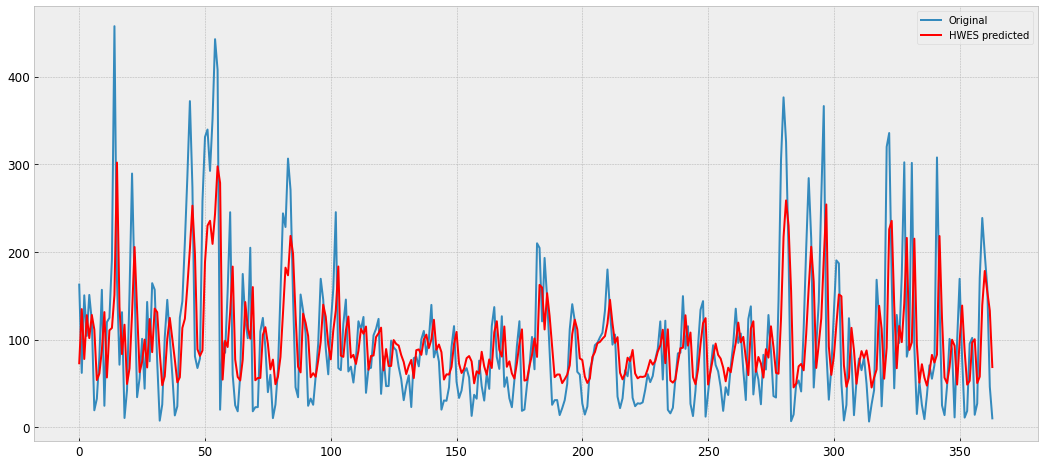

In [9]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='HWES predicted')
plt.legend()

### Autoregressive integrated moving average (ARIMA)


In [6]:
# ARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(1, 0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 364/364 [00:25<00:00, 14.51it/s]


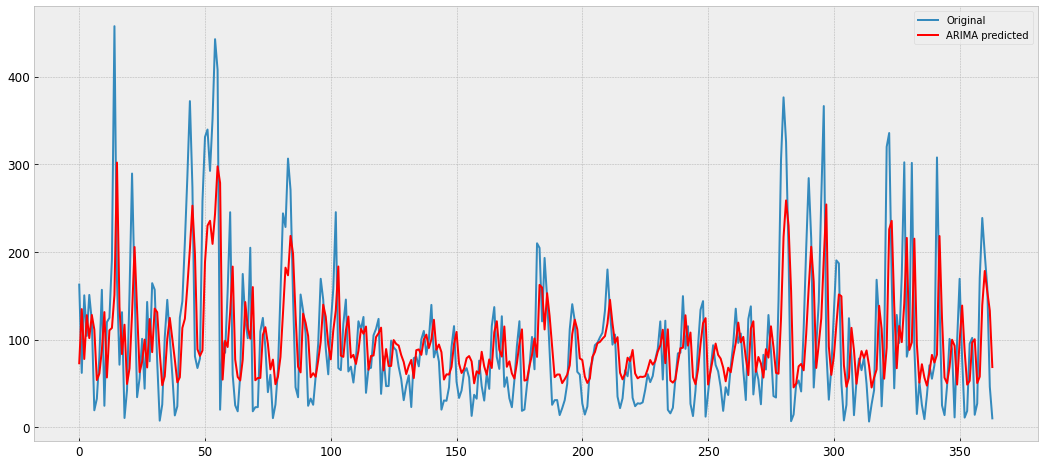

In [7]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

## Multivariate time series forecasting

In [10]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [12]:
X_train_df, y_train = create_time_features(df_training, target='pollution_today')
X_test_df, y_test = create_time_features(df_test, target='pollution_today')
scaler = StandardScaler()
scaler.fit(X_train_df) 
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

## Tree models

### Randomforest

In [15]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Randomforest'] = yhat

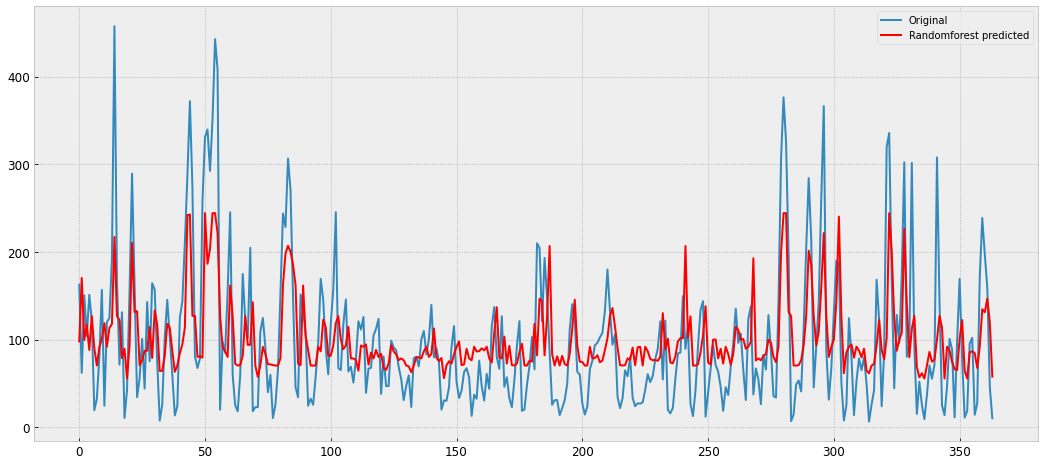

In [17]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat, color='red', label='Randomforest predicted')
plt.legend()

### XGBoost

In [18]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['XGBoost'] = yhat

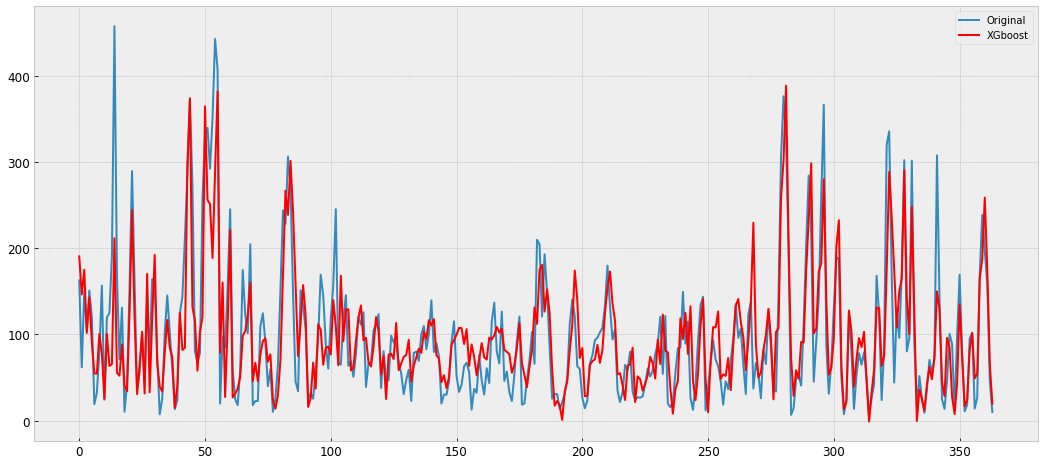

In [19]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

### Lightgbm

In [20]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lightgbm'] = yhat

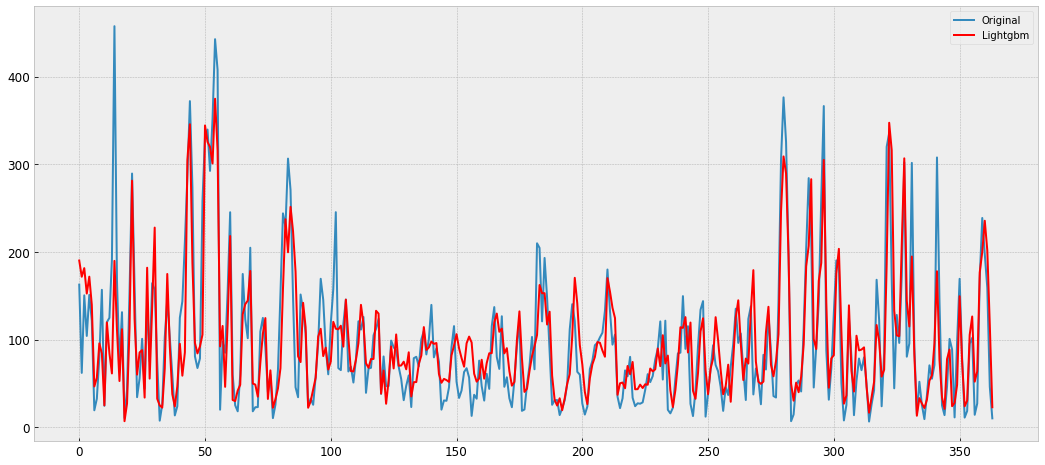

In [21]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat, color='red', label='Lightgbm')
plt.legend()

### Nearest neighbors

In [25]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Kneighbors'] = yhat

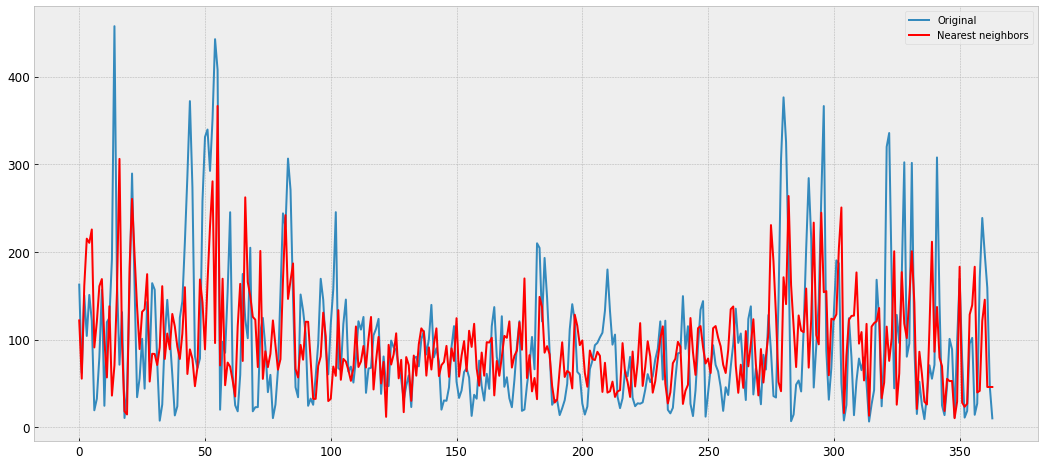

In [26]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat, color='red', label='Nearest neighbors')
plt.legend()

## Deep learning


### Tensorlfow LSTM

In [27]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [28]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')


In [29]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)

Epoch 1/5
200/200 [==============================] - 17s 85ms/step - loss: 52.4530 - val_loss: 44.7995
Epoch 2/5
200/200 [==============================] - 6s 31ms/step - loss: 36.0138 - val_loss: 36.1902
Epoch 3/5
200/200 [==============================] - 6s 31ms/step - loss: 30.2429 - val_loss: 31.1008
Epoch 4/5
200/200 [==============================] - 6s 31ms/step - loss: 27.4843 - val_loss: 31.9176
Epoch 5/5
200/200 [==============================] - 6s 29ms/step - loss: 25.1883 - val_loss: 31.4675


In [31]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

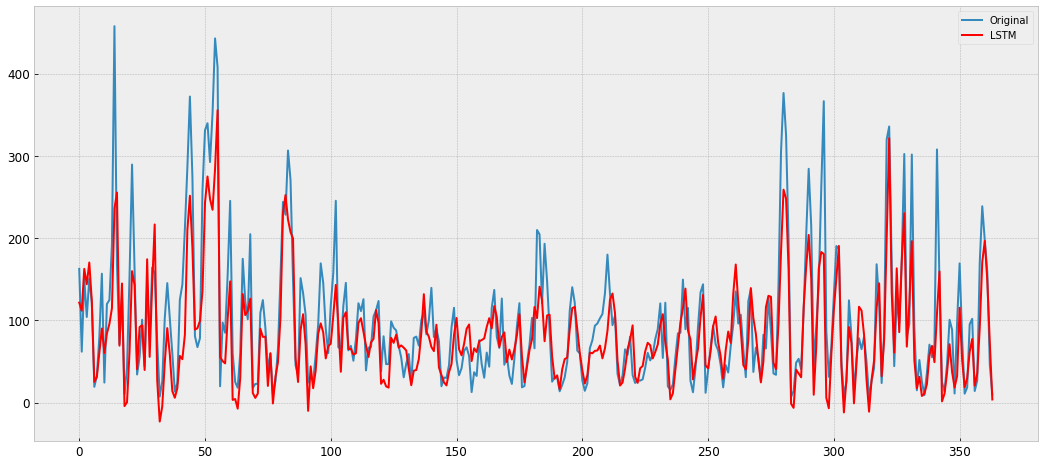

In [32]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat, color='red', label='LSTM')
plt.legend()

## Hyperparameter optimization

Hyperparameter optimization is trying to find the best parameters in an automatic way. We present two methods that are used frequently:

* **Grid search** Brute force method to try all different possible combinations of parameters. Will always find the best combination
* **Bayesian processes** "Brute" force method, optimizes parameter search by using gausian processes to model each parameter distribution and don't go over all the possible values.

### Bayesian processes - Xgboost

In [33]:
def rms(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))


my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3, 15),
    'min_samples_leaf': (1, 4),
    'min_samples_split': (2, 10),
}


def rf_hyper_param(n_estimators,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_jobs=1)

    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))


optimizer = BayesianOptimization(
    f=rf_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [34]:
optimizer.maximize(
    init_points=3,
    n_iter=20,
    acq='ei'
)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.5469   |  8.004    |  3.161    |  2.001    |  3.093e+0 |
|  2        | -0.5111   |  4.761    |  1.277    |  3.49     |  3.521e+0 |
|  3        | -0.5459   |  7.761    |  2.616    |  5.354    |  6.884e+0 |
|  4        | -0.508    |  4.298    |  3.175    |  5.441    |  3.52e+03 |
|  5        | -0.5428   |  7.947    |  3.133    |  9.549    |  3.506e+0 |
|  6        | -0.5457   |  7.243    |  1.491    |  8.858    |  3.524e+0 |
|  7        | -0.4608   |  3.549    |  3.036    |  6.999    |  3.518e+0 |
|  8        | -0.4619   |  3.891    |  2.847    |  7.469    |  3.52e+03 |
|  9        | -0.5392   |  6.417    |  2.061    |  4.706    |  3.516e+0 |
|  10       | -0.5528   |  14.77    |  1.811    |  8.47     |  4.521e+0 |
|  11       | -0.5281   |  5.947    |  2.751    |  8.017    |  3.517e+0 |
|  12       | -0.5379   |  6.627    | 

In [35]:
params = optimizer.max['params']

# Converting the max_depth and n_estimator values from float to int
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params['min_samples_leaf'] = int(params['min_samples_leaf'])
params['min_samples_split'] = int(params['min_samples_split'])

# Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_rf = RandomForestRegressor(**params)
# Change verbose to True if you want to see it train
tunned_rf.fit(X_train, y_train)

yhat = tunned_rf.predict(X_test)
resultsDict['Randomforest tunned'] = evaluate(y_test, yhat)

In [36]:
increase = 1 - (resultsDict['Randomforest tunned']
                ['rmse']/resultsDict['Randomforest']['rmse'])
print(
    f"Bayesian optimized Randomforest is {increase*100}% better than the Randomforest with default parameters")

Bayesian optimized Randomforest is 10.560836174067278% better than the Randomforest with default parameters


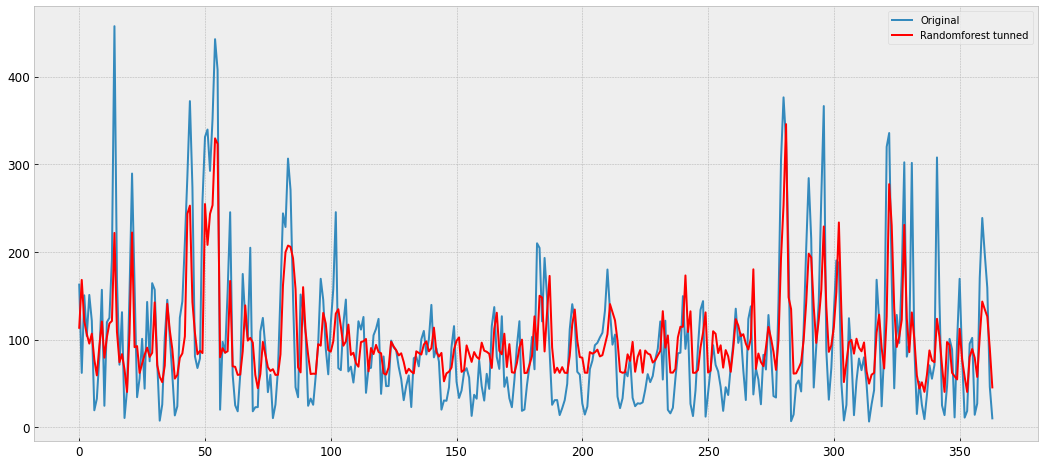

In [37]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat, color='red', label='Randomforest tunned')
plt.legend()

In [40]:
with open('C:/Users/hp/Downloads/time-series-forecasting-with-python-master/results/scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('C:/Users/hp/Downloads/time-series-forecasting-with-python-master/results/predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)